# Azimuthal intigration of MEC data
### For data from `LCLS_MEC` endstation

## Import modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as const
from scipy.optimize import curve_fit
import datetime
import fabio
import math
import os
import pyFAI
from pyFAI.azimuthalIntegrator import AzimuthalIntegrator
import misc_fctns as mf
from sys import platform 
from os.path import exists

%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 6)

## File path and analysis options

In [2]:
# ============ USER INPUTS ================ #

# Path to data files and folders
path = '/users/meera94/Desktop/LCLS MEC LX99' # Main XRD data folder
xrd_data_folder_name = 'Raw_data_LX99'                   # Name of folder containing XRD run folders
calibration_folder_name = 'XRD_calibration_files'   # Name of folder containing calibration (.poni) files
energy_file_name = 'Energies.csv'                   # .csv file containing energies for all the runs

# Input run numbers and time delays 
# run_numbers = [166, 167, 174, 177, 180, 183] # Enter run number
# run_numbers.sort()
# time_delays = [0, 10.5, 13.3, 13.3, 14.3, 15] # Enter time delays in ps (enter 0 if unknown)

run_numbers = [140, 141] #,241,244,250] # Enter run number
#run_numbers = [256, 386, 491] #,241,244,250] # Enter run number
run_numbers.sort()
time_delays = ['ref', 14]
#time_delays = ['ref', 246, 65, 90, 120, 85, 60, 110, 130] #, 17.7, 11.18, 12] # Enter time delays in ps (enter 0 if unknown)

#phase_plate = [300, 150]

# run_numbers = [165, 167, 174, 177, 180, 183] # Enter run number
# time_delays = [0, -3, 0, 0, 1, 1.7] # Enter time delays in ns (enter 0 if unknown)

In [3]:
# Identify system OS to set formatting for path strings
if platform == "linux" or platform == "linux2":
    concat_3 = "{0}/{1}/{2}"
    concat_2 = "{0}/{1}"
elif platform == "darwin":
    concat_3 = "{0}/{1}/{2}"
    concat_2 = "{0}/{1}"
elif platform == "win64":
    concat_3 = "{0}\\{1}\\{2}"
    concat_2 = "{0}\\{1}"
else:
    concat_3 = "{0}\\{1}\\{2}"
    concat_2 = "{0}\\{1}"

In [4]:
# Create a list of run numbers
run_numbers_list = ['run'+ str(number) for number in run_numbers]

# for run in run_numbers:
#     folder_path = concat_3.format(path, xrd_data_folder_name, run)
#     if exists(folder_path):
#         pass
#     else:
#         raise Exception("\nDirectory does not exist!! \n" + "Please check if the directory for files")

# Read energies in KeV
def read_energies(energy_file_name, run_numbers):
    file = open(energy_file_name)
    header_bool = False
    energies = []
    for data in file:
        if header_bool == False:
            header_bool = True
        elif int(data.split(',')[0]) in run_numbers:
            energies.append(float(data.split(',')[1]))
    return energies

energy_file_path = concat_2.format(path, energy_file_name)
E = read_energies(energy_file_path, run_numbers)
print("Energies (eV): ", E)

# Read Gas Norms
def read_gas_norms(run_numbers, default_gas_norm = 0.7):
    import warnings
    run_numbers_list = ['run'+ str(number) for number in run_numbers]
    gas_norm_values = {} # Dict containing all gas_norm values
    # Make a list of paths of all .txt files
    for run in run_numbers_list:
        gas_norm_values[run] = {'event':[], 'value':[]}
        text_file_name = concat_2.format(run, run + '_Bld.txt')
        text_file_path = concat_3.format(path, xrd_data_folder_name, text_file_name)
        header_bool = True
        #if text_file_path
        try:
            data = open(text_file_path)
            event_counter = 0
            for dat in data:
                if header_bool == True:
                    header_bool = False
                else:
                    gas_norm_values[run]['event'].append(event_counter)
                    try:
                        gas_norm_values[run]['value'].append(float(dat.split(' ')[1]))
                    except:
                        warnings.warn(run + " has no value for gas norm, set to " + str(default_gas_norm) + " by default.")
                        gas_norm_values[run]['value'].append(float(default_gas_norm))
                event_counter += 1
        except:
            warnings.warn(run + " has no .txt file. Values set to defaults.")
            gas_norm_values[run]['event'] = [1]
            gas_norm_values[run]['value'] = [default_gas_norm]         

    # Remove negative and non-positive value for gas norm energies
    # Raise warnings and exceptions in such edge cases
    ref_run_bool = True
    for runs in gas_norm_values:
        if ref_run_bool == True: 
            ref_run_bool = False
            old_events = gas_norm_values[runs]['event']
            old_values = gas_norm_values[runs]['value']
            nan_idx = [idx for idx, val in enumerate(old_values) if np.isnan(val) == True]
            neg_idx = [idx for idx, val in enumerate(old_values) if val <= 0]
            remove_idx = nan_idx + neg_idx
            new_events = [evt for idx, evt in enumerate(old_events) if idx not in remove_idx]
            new_values = [val for idx, val in enumerate(old_values) if idx not in remove_idx]
            # Warn if there are multiple values
            if len(nan_idx) > 1: warnings.warn("There are" + str(len(nan_idx)) + "nan values in " + runs)
            elif len(new_values) == 0: raise Exception(runs + "contains only nan/ non-positive gas norm energy values!")
            gas_norm_values[runs]['event'] = new_events
            gas_norm_values[runs]['value'] = new_values
        else:
            if np.isnan(gas_norm_values[runs]['value'][0]) == True:
                gas_norm_values[runs]['value'][0] = default_gas_norm
                #raise Exception(runs + " has an nan gas norm energy value.")
            elif gas_norm_values[runs]['value'][0] <= 0:
                gas_norm_values[runs]['value'][0] = default_gas_norm
                #raise Exception(runs + " has an zero or negative gas norm energy value.")

    # Calculate the appropriate event for the reference
    shot_value = gas_norm_values[run_numbers_list[1]]['value'][0]
    diffs = [np.abs(val - shot_value) for val in gas_norm_values[run_numbers_list[0]]['value']]
    ref_event_idx = np.argmin(diffs)
    ref_event = gas_norm_values[run_numbers_list[0]]['event'][ref_event_idx]

    # Compile list of gas norm values
    gas_norms = []
    ref_run_bool = True
    for runs in gas_norm_values: 
        if ref_run_bool == True:
            gas_norms.append(gas_norm_values[runs]['value'][ref_event_idx])
            ref_run_bool = False
        else:
            gas_norms.append(gas_norm_values[runs]['value'][0])
    return gas_norms, ref_event

Gas_norm, ref_evt = read_gas_norms(run_numbers)
ref_evt_string = 'evt_' + str(int(ref_evt)) + '_'

print("Gas norms: ", Gas_norm)
print("Reference event: ", ref_evt, " of ", type(ref_evt))

# Convert energy (eV) to wavelength (m)
def get_wavelengths(E):
    lams = []
    h = const.h # Planck's constant in Js
    c = const.c # Speed of light in m/s
    e = const.e # Electron charge in Coulomb
    # E in eV
    return [h*c/(e*energy) for energy in E]
lams = get_wavelengths(E)
print("Wavelengths (m): ", lams)

# Ensure all the data input is complete
if len(time_delays) != len(run_numbers): 
    raise Exception("Every run must be assigned a time delay!") 

# Assign names to all the runs
number_of_runs = len(run_numbers)
for j in range(number_of_runs):
    if j == 0:
        exec('run_' + str(j) + '= "Run_' + str(run_numbers[j]) + '_Ref"')
    else:
        exec('run_' + str(j) + '= "Run_' + str(run_numbers[j]) + '_' + str(time_delays[j]) + '_ns"')

Energies (eV):  [17200.8, 17200.7]
Gas norms:  [0.705392, 0.7]
Reference event:  1  of  <class 'int'>
Wavelengths (m):  [7.208048371773423e-11, 7.208090277325937e-11]


/var/folders/rr/p__ksfks4dn5cpjvv_0kgnl80000gn/T/ipykernel_69835/1127616180.py:54: UserWarning: run141 has no .txt file. Values set to defaults.
  warnings.warn(run + " has no .txt file. Values set to defaults.")


In [5]:
label_list = []
for j in range(number_of_runs):
    if 'phase_plate' in locals():
        if j == 0:
           label_list.append("Run_" + str(run_numbers[j]) + '_' + str(phase_plate[j]) + '_um_phase_plt' + "_Ref")
        else:
            label_list.append("Run_" + str(run_numbers[j]) + '_' + str(phase_plate[j]) + '_um_phase_plt' + '_' + str(time_delays[j]) + " ns")
            #label_list.append("Run_" + str(run_numbers[j]) + '_' + str(time_delays[j]) + "_")
    else:
        if j == 10:
           label_list.append("Run_" + str(run_numbers[j]) + "_Ref")
        else:
            label_list.append("Run_" + str(run_numbers[j]) + '_' + str(time_delays[j]) + " GPa")
            #label_list.append("Run_" + str(run_numbers[j]) + '_' + str(time_delays[j]) + "_")

In [6]:
label_list

['Run_140_ref GPa', 'Run_141_14 GPa']

## Get list of files to analyze
- This section adapted from Emmauelle Jal's example (2020-07-23)

In [7]:
# Image data
li_file_im = []
path_im = {}
ref_bool = True
for run_number in run_numbers_list:
    temp_path = concat_3.format(path, xrd_data_folder_name, run_number)
    tiff_files = mf.ls(path = temp_path,\
                      st = ".tif",\
                      show = False,\
                      ret = "name")
    if ref_bool == True:
        li_file_im += [string for string in tiff_files if ref_evt_string in string and 'visar' not in string]
        ref_bool = False 
    else:
        if len(li_file_im) == 0: print("Not reading reference file!")
        li_file_im += [string for string in tiff_files if 'evt_1_' in string and 'visar' not in string]   
    path_im["{0}".format(run_number)] = temp_path
nb_file_im = len(li_file_im)

# Calib files
path_calib = concat_2.format(path, calibration_folder_name)
li_file_calib = mf.ls(path = path_calib,\
              st = ".poni",\
              show = False,\
              ret = "name")
nb_file_calib = len(li_file_calib)

print("Number of image files = ", nb_file_im)
print("Number of calibration files = ", nb_file_calib)

Number of image files =  8
Number of calibration files =  4


In [8]:
path_im

{'run140': '/users/meera94/Desktop/LCLS MEC LX99/Raw_data_LX99/run140',
 'run141': '/users/meera94/Desktop/LCLS MEC LX99/Raw_data_LX99/run141'}

In [9]:
li_file_im

['Run_140_evt_1_Epix10kaQuad0.tiff',
 'Run_140_evt_1_Epix10kaQuad1.tiff',
 'Run_140_evt_1_Epix10kaQuad2.tiff',
 'Run_140_evt_1_Epix10kaQuad3.tiff',
 'Run_141_evt_1_Epix10kaQuad0.tiff',
 'Run_141_evt_1_Epix10kaQuad1.tiff',
 'Run_141_evt_1_Epix10kaQuad2.tiff',
 'Run_141_evt_1_Epix10kaQuad3.tiff']

# Loading all the detector and calib files

In [10]:
# Loading all the TIFF files and doing rotations

rot_mat = [-1, 1, 0, 1]
rot_angles = ["-90", "+90", "0", "+90"]
print("=== Images ===")
run_imgs = {}
counter = 0
for run_number in run_numbers_list:
    imgs = {}
    for i in range(nb_file_calib):
        name_file_im = li_file_im[i+4*counter]
        path_im_i = concat_2.format(path_im["{0}".format(run_number)], name_file_im)
        imgs["Quad{0}".format(i)] = np.rot90(np.flipud(fabio.open(path_im_i).data), rot_mat[i])/Gas_norm[counter]
        #imgs["Quad{0}".format(i)] = np.rot90(np.flipud(fabio.open(path_im_i).data), rot_mat[i])/1
        print("\nQuad{0}".format(i), f"{rot_angles[i]} deg rotation")
        print(name_file_im)
    counter = counter + 1
    run_imgs["{0}".format(run_number)] = imgs

=== Images ===

Quad0 -90 deg rotation
Run_140_evt_1_Epix10kaQuad0.tiff

Quad1 +90 deg rotation
Run_140_evt_1_Epix10kaQuad1.tiff

Quad2 0 deg rotation
Run_140_evt_1_Epix10kaQuad2.tiff

Quad3 +90 deg rotation
Run_140_evt_1_Epix10kaQuad3.tiff

Quad0 -90 deg rotation
Run_141_evt_1_Epix10kaQuad0.tiff

Quad1 +90 deg rotation
Run_141_evt_1_Epix10kaQuad1.tiff

Quad2 0 deg rotation
Run_141_evt_1_Epix10kaQuad2.tiff

Quad3 +90 deg rotation
Run_141_evt_1_Epix10kaQuad3.tiff


In [11]:
len(run_imgs)

2

In [12]:
ai_dic = {}

# Loading Calib files
print("=== Calibration ===")
for i in range(0, nb_file_calib):
    name_file_calib = li_file_calib[i]
    path_calib_i = "{0}\{1}".format(path_calib, name_file_calib)
    ai_dic["Quad{0}".format(i)] = pyFAI.load(path_calib + '/' + li_file_calib[i])
    print(name_file_calib)
    print("\nIntegrator: \n", ai_dic["Quad{0}".format(i)])
    print("\n")

=== Calibration ===
Quad0.poni

Integrator: 
 Detector Detector	 Spline= None	 PixelSize= 1.000e-04, 1.000e-04 m
Wavelength= 6.892990e-11m
SampleDetDist= 2.736570e-01m	PONI= 7.698485e-02, 1.136136e-01m	rot1=0.058864  rot2= -0.516038  rot3= 0.000008 rad
DirectBeamDist= 315.173mm	Center: x=974.865, y=-785.336 pix	Tilt=29.741 deg  tiltPlanRotation= -95.920 deg


Quad1.poni

Integrator: 
 Detector Detector	 Spline= None	 PixelSize= 1.000e-04, 1.000e-04 m
Wavelength= 6.892990e-11m
SampleDetDist= 2.787897e-01m	PONI= 1.248804e-01, 6.882927e-03m	rot1=0.028292  rot2= -0.583100  rot3= 0.000015 rad
DirectBeamDist= 334.110mm	Center: x=-10.068, y=-590.851 pix	Tilt=33.444 deg  tiltPlanRotation= -92.456 deg


Quad2.poni

Integrator: 
 Detector Detector	 Spline= None	 PixelSize= 1.000e-04, 1.000e-04 m
Wavelength= 7.290000e-11m
SampleDetDist= 1.294574e-01m	PONI= -2.170365e-02, 5.547792e-02m	rot1=-0.023724  rot2= -0.565686  rot3= -0.000048 rad
DirectBeamDist= 153.389mm	Center: x=585.497, y=-1039.192 pix

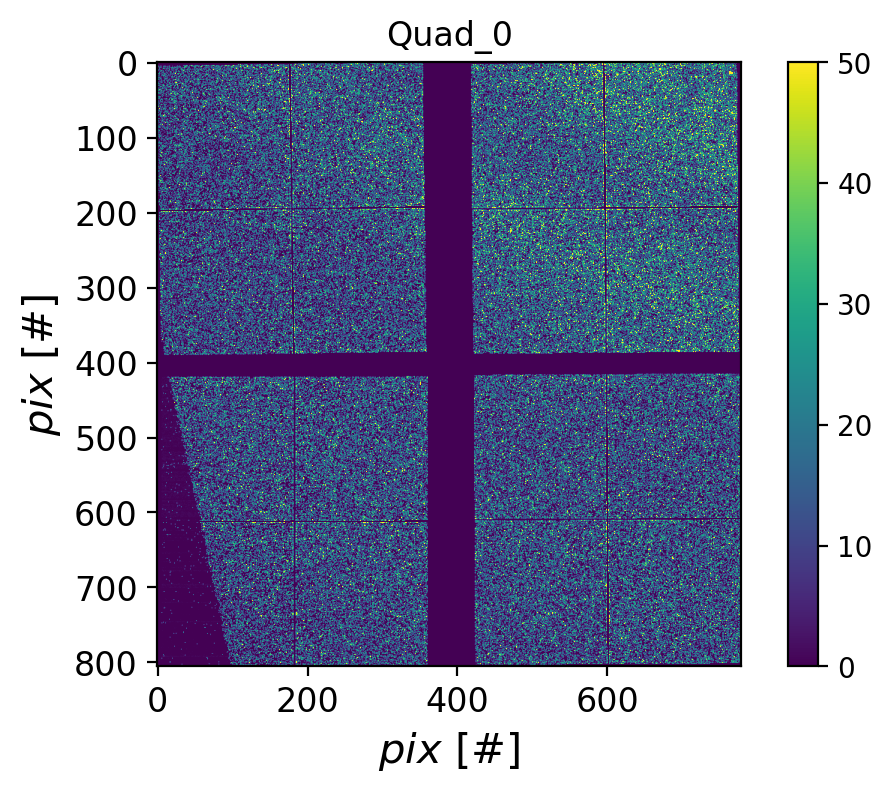

In [13]:
%matplotlib inline
Quad_to_plot = 0
plt.rcParams['figure.dpi']= 200
plt.imshow(imgs["Quad{0}".format(Quad_to_plot)], vmin=0, vmax=50)             # Display as an image
#plt.axis('equal')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('$pix$ [#]',fontsize=15)
plt.ylabel('$pix$ [#]',fontsize=15)
plt.title(f'Quad_{Quad_to_plot}')
plt.colorbar()
plt.show() 

# Integrating in 1D

In [14]:
lams

[7.208048371773423e-11, 7.208090277325937e-11]

In [15]:
run_numbers_list

['run140', 'run141']

In [16]:
int_1D_all = {}
counter = 0
mask_run = {}
# Integrating
for run_number in run_numbers_list:
    int_1D_temp = {}
    mask_for_quad = {}
    for i in range(0, nb_file_calib):
        #img_array = imgs["Quad{0}".format(i)]
        img_array = run_imgs[run_number]["Quad{0}".format(i)]
        norm_per_img = np.mean(img_array)
        #norm_per_img = 1
        mask1 = img_array<1
        mask2 = img_array>2000
        mask_for_quad["Quad{0}".format(i)] = mask1+mask2
        ai_dic["Quad{0}".format(i)].wavelength = lams[counter]
        int_1D_temp["Quad{0}".format(i)] = ai_dic["Quad{0}".format(i)].integrate1d(img_array/norm_per_img, 1000, mask = mask_for_quad["Quad{0}".format(i)], unit="2th_deg")
        print("Done Integrating", run_number, "Quad{0}".format(i), "\n")
    counter = counter + 1
    int_1D_all[run_number] = int_1D_temp
    mask_run[run_number] = mask_for_quad

Done Integrating run140 Quad0 

Done Integrating run140 Quad1 

Done Integrating run140 Quad2 

Done Integrating run140 Quad3 

Done Integrating run141 Quad0 

Done Integrating run141 Quad1 

Done Integrating run141 Quad2 

Done Integrating run141 Quad3 



In [17]:
# run_to_plot = 'run158'
# quad_2_plot = 0

# #fig, ax = subplots(1,2, figsize=(15,5))
# I = mask_run[run_to_plot]["Quad{0}".format(quad_2_plot)]
# plt.imshow(I, origin="lower", aspect="auto")
# plt.xlabel("2 theta (deg)")
# plt.ylabel("Azimuthal angle chi (deg)")
# plt.colorbar()

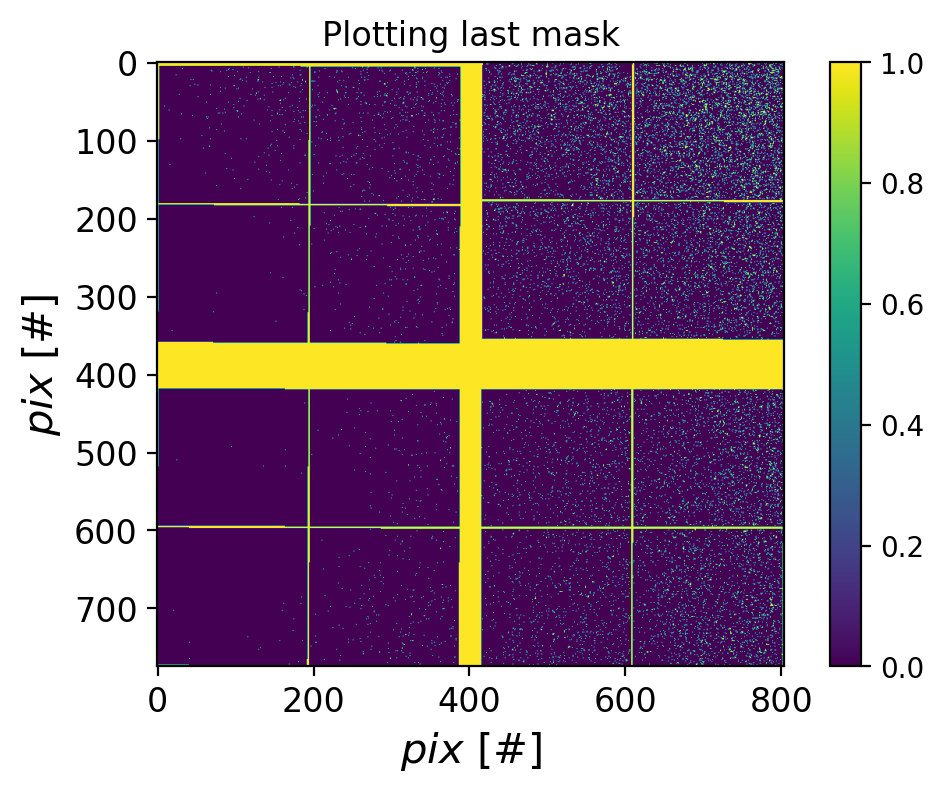

In [18]:
%matplotlib inline
plt.rcParams['figure.dpi']= 200
plt.imshow(mask1+mask2)             # Display as an image
#plt.axis('equal')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('$pix$ [#]',fontsize=15)
plt.ylabel('$pix$ [#]',fontsize=15)
plt.title('Plotting last mask')
plt.colorbar()
plt.show() 

# Moving avg

In [19]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [20]:
# Set if you want moving avg
move_avg = True
num_points_avg = 100

In [21]:
move_avg_list = [True,False,False,False,False,False,False,False,False]

In [22]:
counter = 0
int_1D_mvg_avg = {}
# Integrating
if move_avg == True:
    for run_number in run_numbers_list:
        if move_avg_list[counter] == True:
            int_1D_temp = {}
            for i in range(0, nb_file_calib):
                int_1D_temp["Quad{0}".format(i)] = moving_average(int_1D_all[run_number]["Quad{0}".format(i)][1][:], num_points_avg)
                print("Done moving avg", run_number, "Quad{0}".format(i), "\n")
            counter = counter + 1
            int_1D_mvg_avg[run_number] = int_1D_temp
        else:
            pass
else:
    pass

Done moving avg run140 Quad0 

Done moving avg run140 Quad1 

Done moving avg run140 Quad2 

Done moving avg run140 Quad3 



# Plotting data

In [23]:
np.size(int_1D_all)

1

In [24]:
len(int_1D_all)

2

In [25]:
label_list

['Run_140_ref GPa', 'Run_141_14 GPa']

In [26]:
clrs = ['k', 'b', 'g', 'r', 'gold','tab:orange','navy','purple','deeppink' ] 
#clrs = ['k', 'b', 'g', 'r', 'gold','tab:orange','purple'] 
#clrs = ['k', 'b', 'g', 'r', 'gold']

In [27]:
#offs = [10, -100, 1, 1, 1.5, 1.5, 2, 1.5, 1.5]
offs = [1,1,1,1,1,1,1,1,1]
offnorm = [40,1,1,1,1,1,1,1,1]

<function matplotlib.pyplot.show(close=None, block=None)>

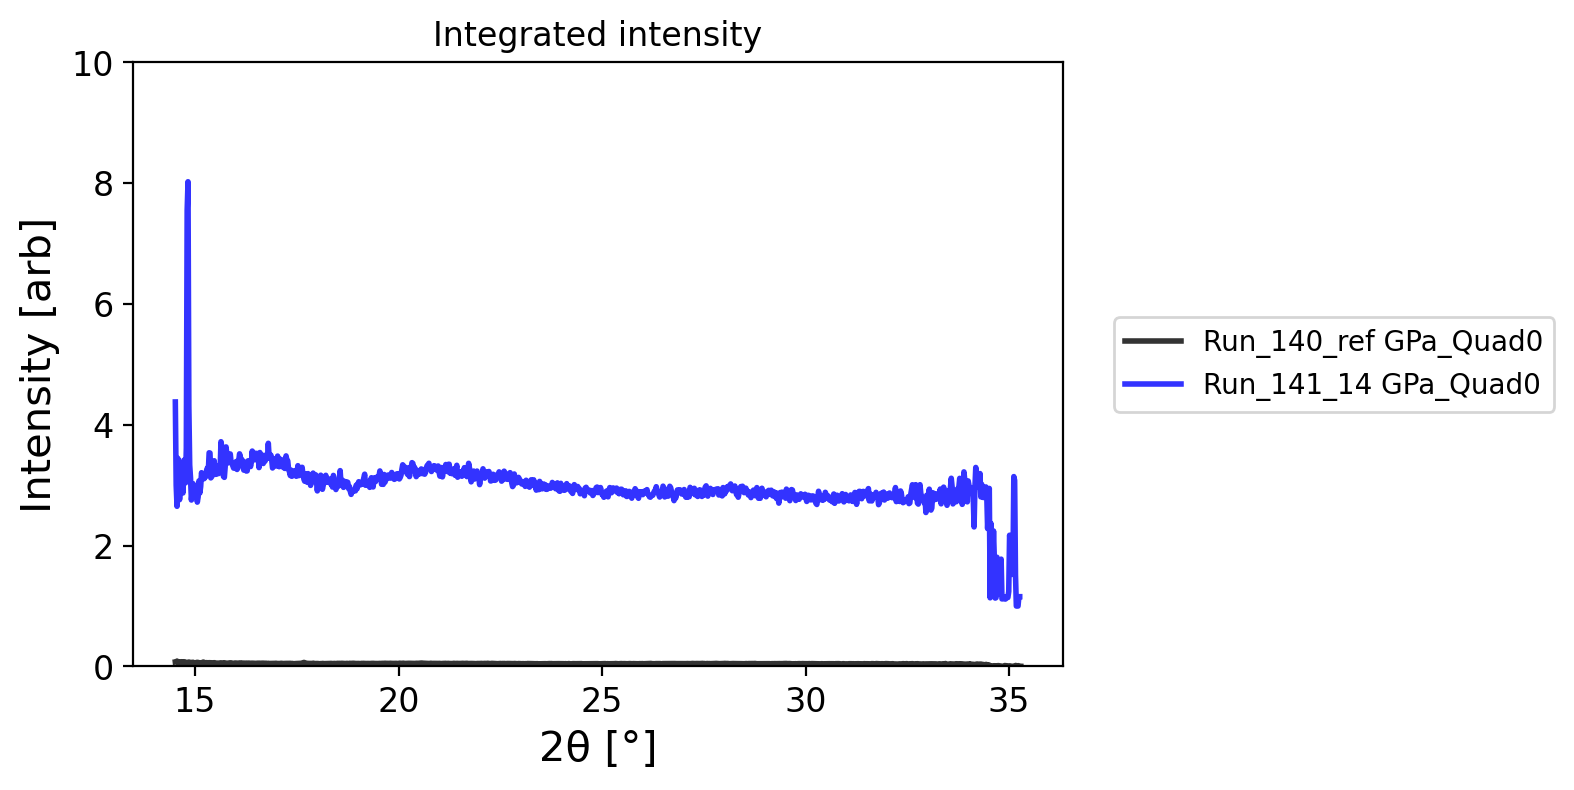

In [29]:
%matplotlib inline
plt.rcParams['figure.dpi']= 200
quad_2_plot = 0
counter = 0
for run_number in run_numbers_list:
    # i= k*4
    # i = k*4 + quad_2_plot #1
    plt.plot(int_1D_all[run_number]["Quad{0}".format(quad_2_plot)][0][:], int_1D_all[run_number]["Quad{0}".format(quad_2_plot)][1][:]/offnorm[counter]\
             +counter*offs[counter], label = label_list[counter] + "_Quad{0}".format(quad_2_plot),linewidth = 2, alpha = 0.8, color=clrs[counter])
    counter = counter + 1
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('2\u03B8 [\N{DEGREE SIGN}]',fontsize=15)
plt.ylabel('Intensity [arb]',fontsize=15)
plt.title("Integrated intensity")
# plt.xlim([15, 32])
plt.ylim([0, 10])
plt.legend(loc = 'center left', bbox_to_anchor = (1.04, 0.5))
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

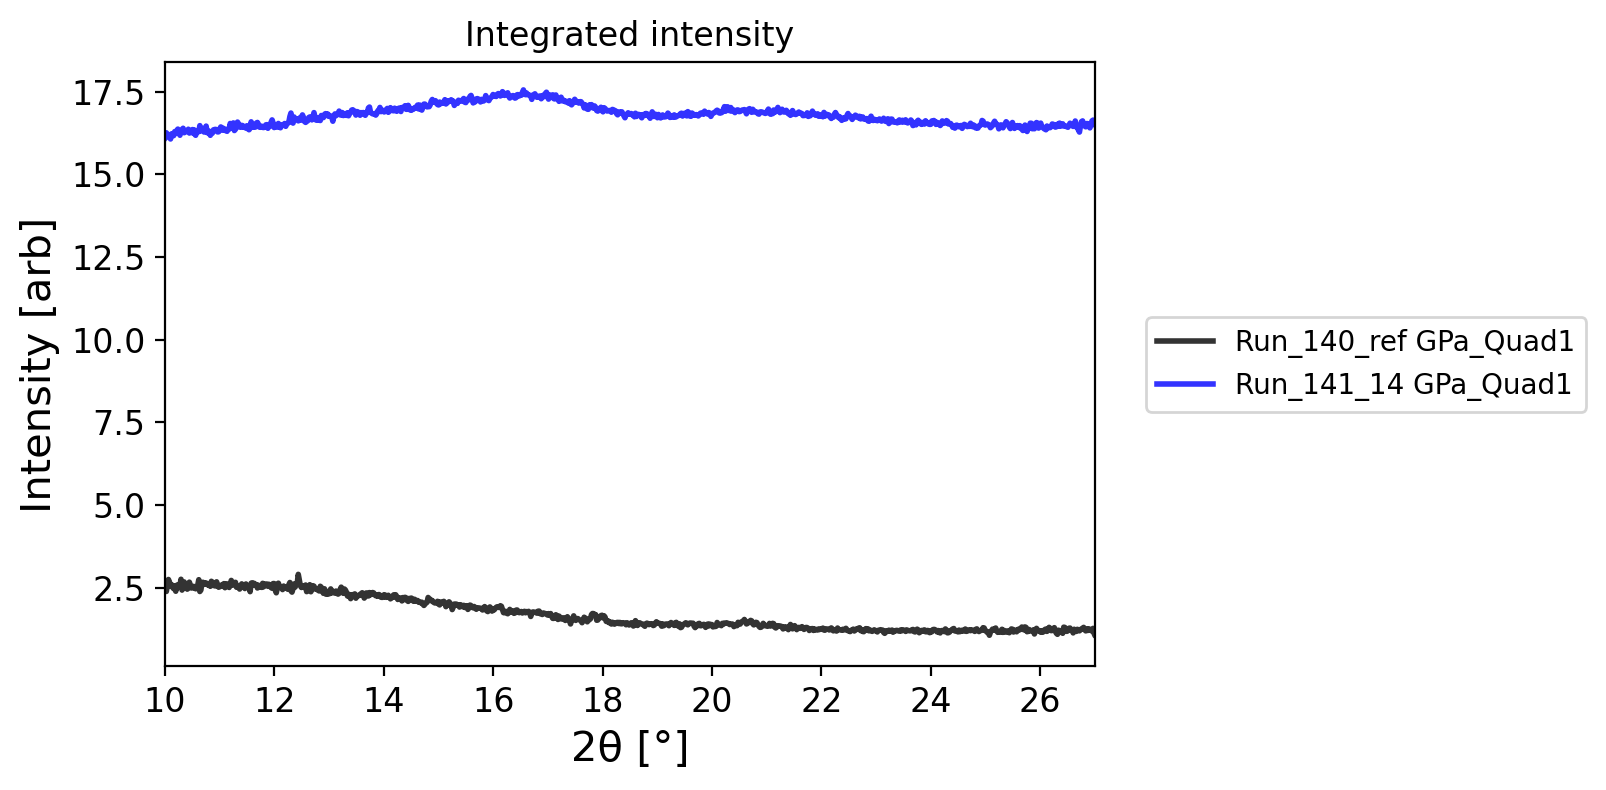

In [30]:
%matplotlib inline
plt.rcParams['figure.dpi']= 200
quad_2_plot = 1
counter = 0
for run_number in run_numbers_list:
    # i= k*4
    # i = k*4 + quad_2_plot #1
    plt.plot(int_1D_all[run_number]["Quad{0}".format(quad_2_plot)][0][:], int_1D_all[run_number]["Quad{0}".format(quad_2_plot)][1][:]\
             +counter*15, label = label_list[counter] + "_Quad{0}".format(quad_2_plot),linewidth = 2, alpha = 0.8, color=clrs[counter])
    counter = counter + 1
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('2\u03B8 [\N{DEGREE SIGN}]',fontsize=15)
plt.ylabel('Intensity [arb]',fontsize=15)
plt.title("Integrated intensity")
plt.xlim([10, 27])
#plt.ylim([0, 150])
plt.legend(loc = 'center left', bbox_to_anchor = (1.04, 0.5))
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

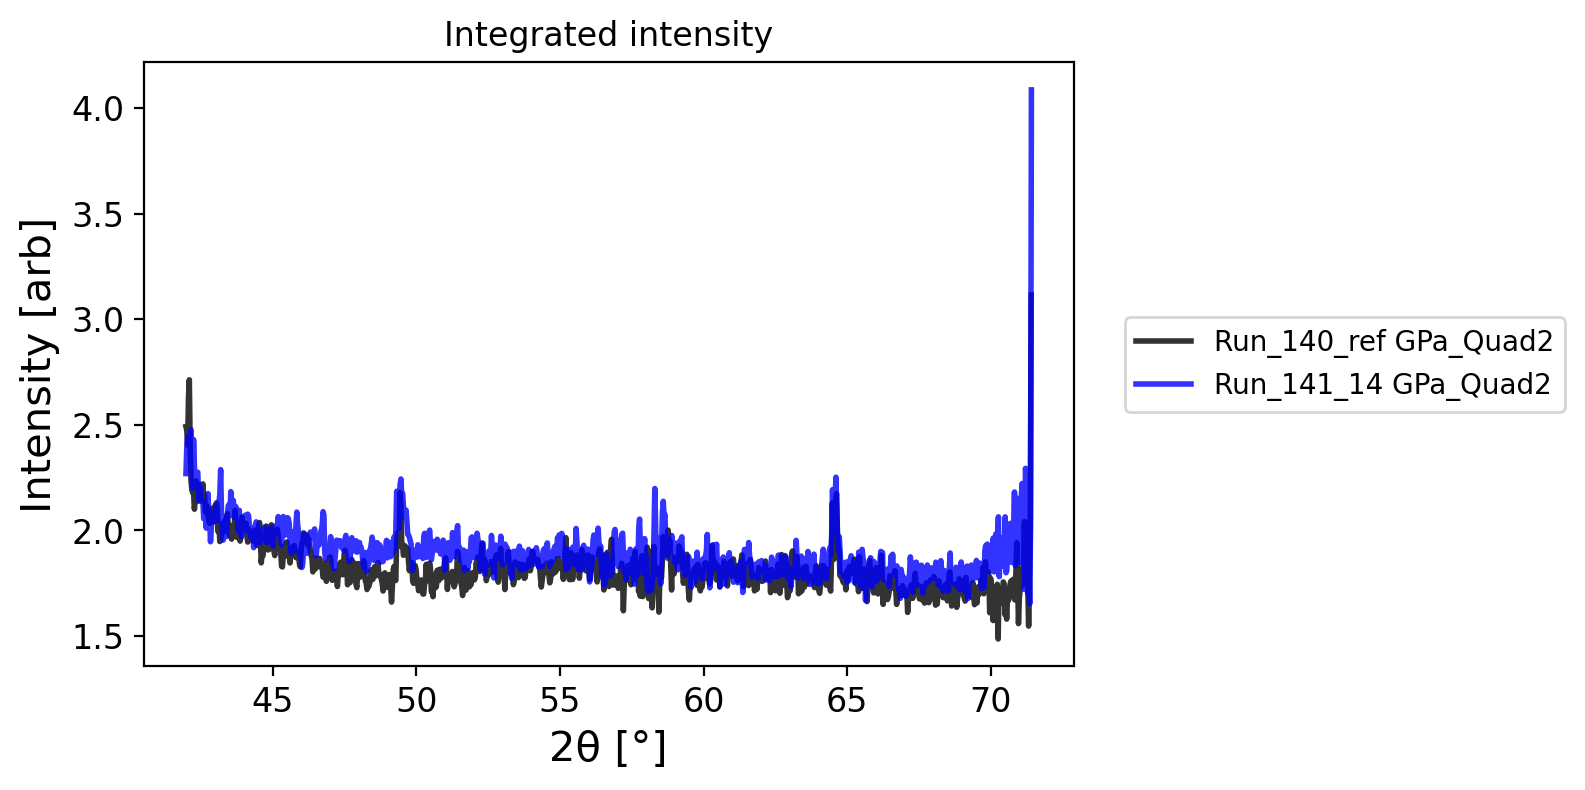

In [31]:
%matplotlib inline
plt.rcParams['figure.dpi']= 200
quad_2_plot = 2
counter = 0
for run_number in run_numbers_list:
    # i= k*4
    # i = k*4 + quad_2_plot #1
    plt.plot(int_1D_all[run_number]["Quad{0}".format(quad_2_plot)][0][:], int_1D_all[run_number]["Quad{0}".format(quad_2_plot)][1][:]\
             +counter*0, label = label_list[counter] + "_Quad{0}".format(quad_2_plot),linewidth = 2, alpha = 0.8,color=clrs[counter])
    counter = counter + 1
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('2\u03B8 [\N{DEGREE SIGN}]',fontsize=15)
plt.ylabel('Intensity [arb]',fontsize=15)
plt.title("Integrated intensity")
#plt.ylim([10, 20])
plt.legend(loc = 'center left', bbox_to_anchor = (1.04, 0.5))
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

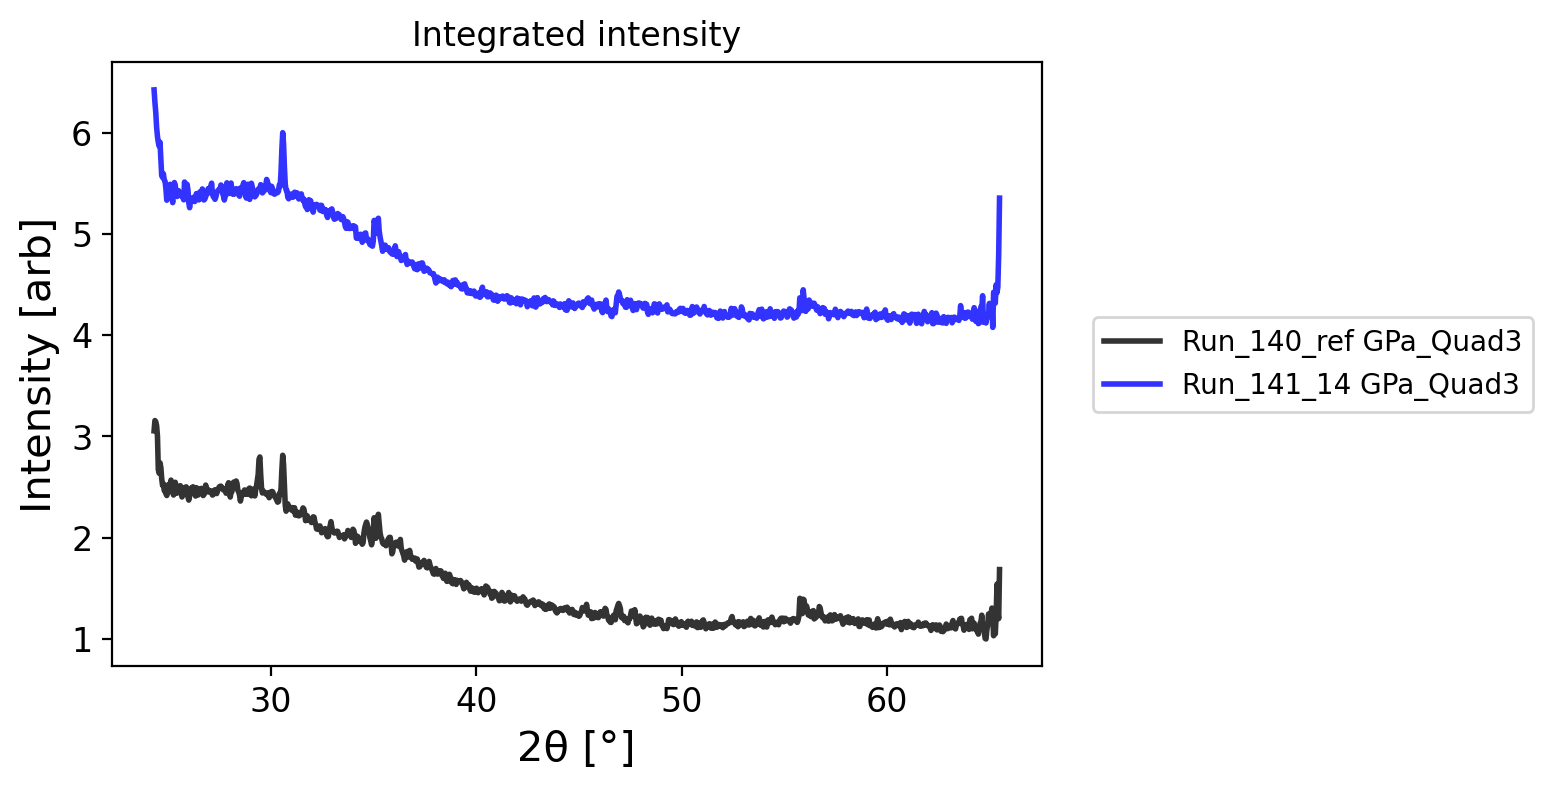

In [32]:
%matplotlib inline
plt.rcParams['figure.dpi']= 200
quad_2_plot = 3
counter = 0
for run_number in run_numbers_list:
    # i= k*4
    # i = k*4 + quad_2_plot #1
    plt.plot(int_1D_all[run_number]["Quad{0}".format(quad_2_plot)][0][:], int_1D_all[run_number]["Quad{0}".format(quad_2_plot)][1][:]\
             +counter*3, label = label_list[counter] + "_Quad{0}".format(quad_2_plot),linewidth = 2, alpha = 0.8,color=clrs[counter])
    counter = counter + 1
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('2\u03B8 [\N{DEGREE SIGN}]',fontsize=15)
plt.ylabel('Intensity [arb]',fontsize=15)
plt.title("Integrated intensity")
#plt.ylim([10, 20])
plt.legend(loc = 'center left', bbox_to_anchor = (1.04, 0.5))
plt.show

# Plotting without offset

<function matplotlib.pyplot.show(close=None, block=None)>

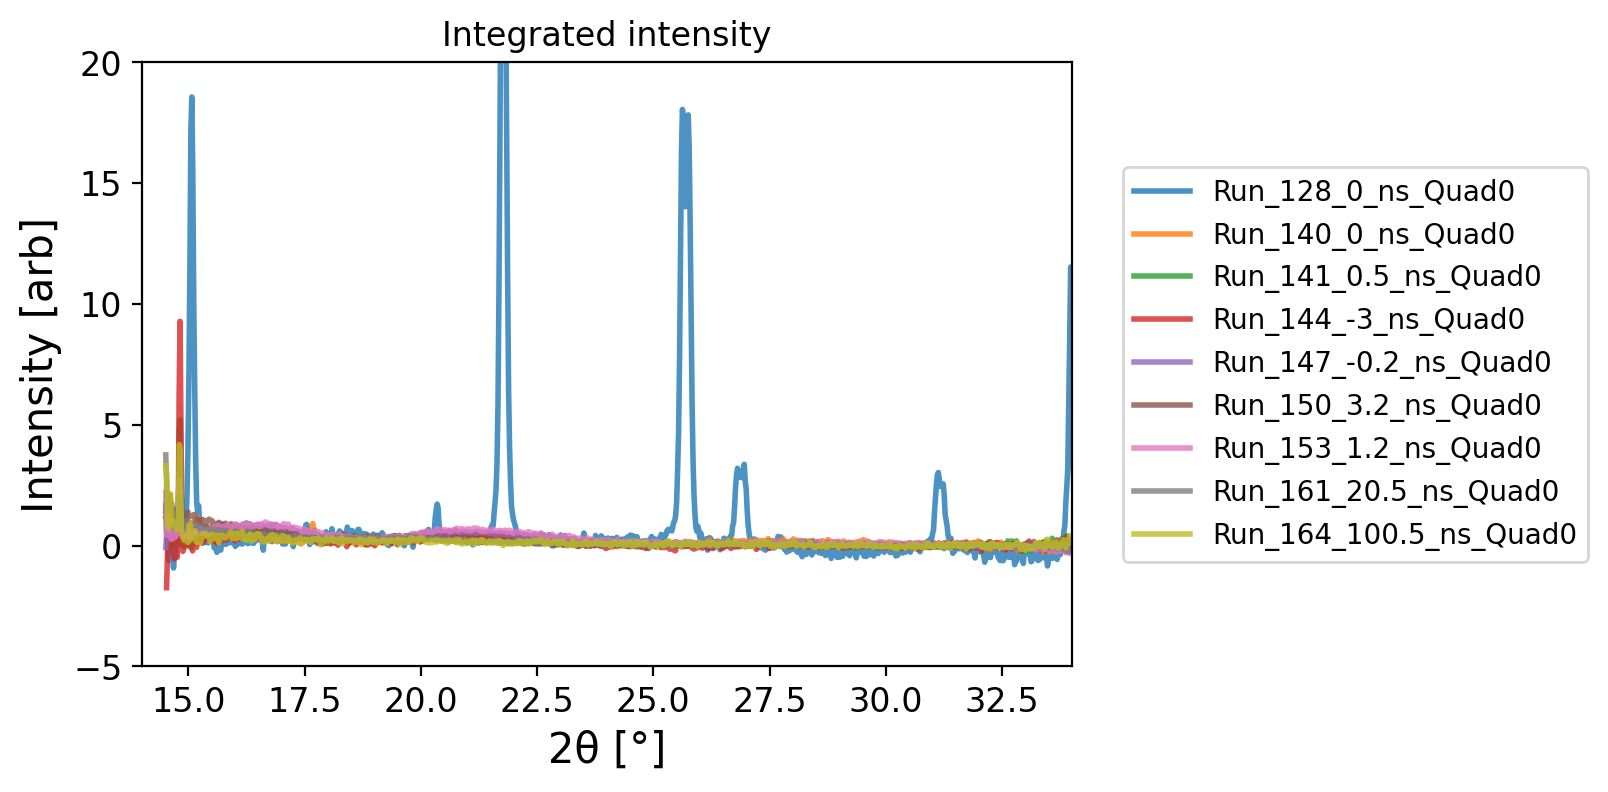

In [33]:
%matplotlib inline
plt.rcParams['figure.dpi']= 200
quad_2_plot = 0
counter = 0
for run_number in run_numbers_list:
    # i= k*4
    # i = k*4 + quad_2_plot #1
    plt.plot(int_1D_all[run_number]["Quad{0}".format(quad_2_plot)][0][:], int_1D_all[run_number]["Quad{0}".format(quad_2_plot)][1][:]-np.mean(int_1D_all[run_number]["Quad{0}".format(quad_2_plot)][1][800:900])\
             , label = label_list[counter] + "_Quad{0}".format(quad_2_plot), linewidth = 2, alpha = 0.8)
    counter = counter + 1
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('2\u03B8 [\N{DEGREE SIGN}]',fontsize=15)
plt.ylabel('Intensity [arb]',fontsize=15)
plt.title("Integrated intensity")
plt.xlim([14, 34])
plt.ylim([-5, 20])
plt.legend(loc = 'center left', bbox_to_anchor = (1.04, 0.5))
plt.show

In [34]:
%matplotlib inline
plt.rcParams['figure.dpi']= 200
quad_2_plot = 1
counter = 0
for run_number in run_numbers_list:
    # i= k*4
    # i = k*4 + quad_2_plot #1
    plt.plot(int_1D_all[run_number]["Quad{0}".format(quad_2_plot)][0][:], int_1D_all[run_number]["Quad{0}".format(quad_2_plot)][1][:]\
             , label = label_list[counter] + "_Quad{0}".format(quad_2_plot), linewidth = 2, alpha = 0.8,color=clrs[counter])
    counter = counter + 1
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('2\u03B8 [\N{DEGREE SIGN}]',fontsize=15)
plt.ylabel('Intensity [arb]',fontsize=15)
plt.title("Integrated intensity")
#plt.xlim([14, 34])
plt.legend(loc = 'center left', bbox_to_anchor = (1.04, 0.5))
plt.show

NameError: name 'clrs' is not defined

In [35]:
%matplotlib inline
plt.rcParams['figure.dpi']= 200
quad_2_plot = 2
counter = 0
for run_number in run_numbers_list:
    # i= k*4
    # i = k*4 + quad_2_plot #1
    plt.plot(int_1D_all[run_number]["Quad{0}".format(quad_2_plot)][0][:], int_1D_all[run_number]["Quad{0}".format(quad_2_plot)][1][:]\
             , label = label_list[counter] + "_Quad{0}".format(quad_2_plot), linewidth = 2, alpha = 0.8,color=clrs[counter])
    counter = counter + 1
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('2\u03B8 [\N{DEGREE SIGN}]',fontsize=15)
plt.ylabel('Intensity [arb]',fontsize=15)
plt.title("Integrated intensity")
#plt.xlim([14, 34])
plt.legend(loc = 'center left', bbox_to_anchor = (1.04, 0.5))
plt.show

NameError: name 'clrs' is not defined

In [30]:
clrs = ['k', 'b', 'g', 'r', 'y' ] 


<function matplotlib.pyplot.show(close=None, block=None)>

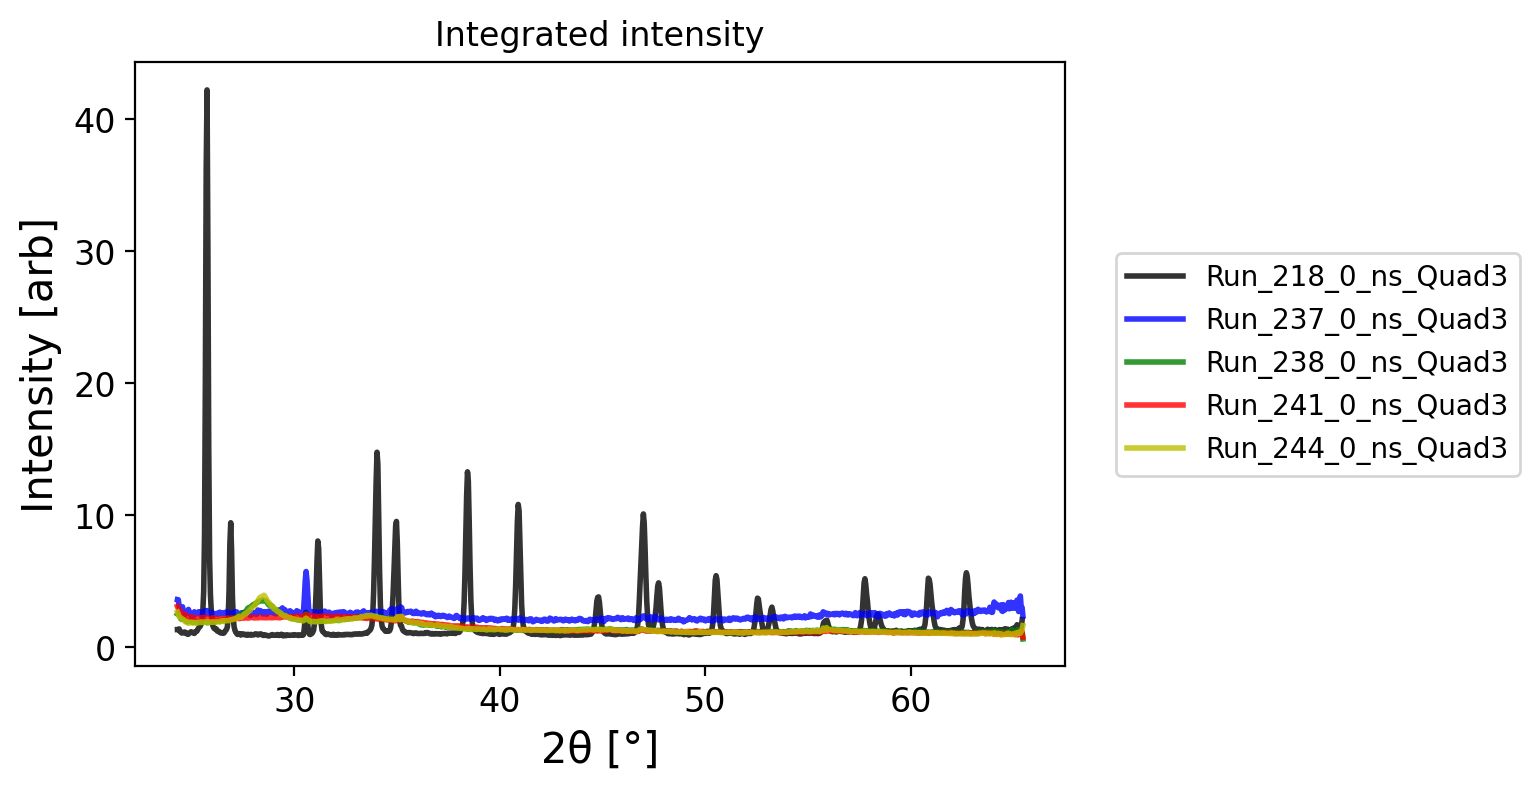

In [31]:
%matplotlib inline
plt.rcParams['figure.dpi']= 200
quad_2_plot = 3
counter = 0
for run_number in run_numbers_list:
    # i= k*4
    # i = k*4 + quad_2_plot #1
    plt.plot(int_1D_all[run_number]["Quad{0}".format(quad_2_plot)][0][:], int_1D_all[run_number]["Quad{0}".format(quad_2_plot)][1][:]\
             , label = label_list[counter] + "_Quad{0}".format(quad_2_plot), linewidth = 2, alpha = 0.8, color=clrs[counter])
    counter = counter + 1
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('2\u03B8 [\N{DEGREE SIGN}]',fontsize=15)
plt.ylabel('Intensity [arb]',fontsize=15)
plt.title("Integrated intensity")
#plt.xlim([14, 34])
plt.legend(loc = 'center left', bbox_to_anchor = (1.04, 0.5))
plt.show

# Plotting all quads together

<function matplotlib.pyplot.show(close=None, block=None)>

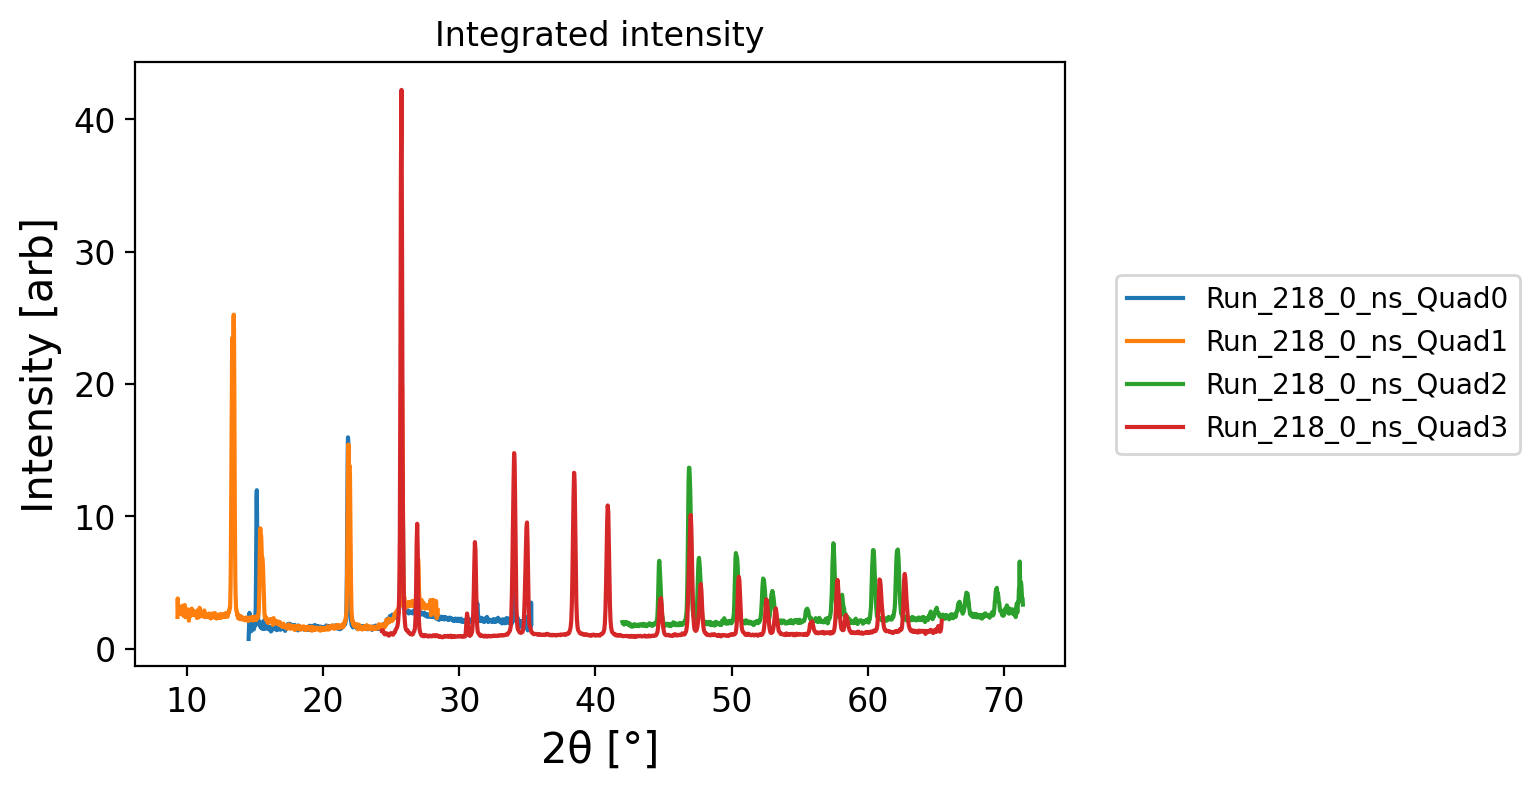

In [62]:
%matplotlib inline
plt.rcParams['figure.dpi']= 200

run_number = run_numbers_list[0]
quad_2_plot = 0
counter = run_numbers_list.index(run_number)
plt.plot(int_1D_all[run_number]["Quad{0}".format(quad_2_plot)][0][:], int_1D_all[run_number]["Quad{0}".format(quad_2_plot)][1][:]\
         , label = label_list[counter] + "_Quad{0}".format(quad_2_plot))

run_number = run_numbers_list[0]
quad_2_plot = 1
counter = run_numbers_list.index(run_number)
plt.plot(int_1D_all[run_number]["Quad{0}".format(quad_2_plot)][0][:], int_1D_all[run_number]["Quad{0}".format(quad_2_plot)][1][:]\
         , label = label_list[counter] + "_Quad{0}".format(quad_2_plot))

run_number = run_numbers_list[0]
quad_2_plot = 2
counter = run_numbers_list.index(run_number)
plt.plot(int_1D_all[run_number]["Quad{0}".format(quad_2_plot)][0][:], int_1D_all[run_number]["Quad{0}".format(quad_2_plot)][1][:]\
         , label = label_list[counter] + "_Quad{0}".format(quad_2_plot))

run_number = run_numbers_list[0]
quad_2_plot = 3
counter = run_numbers_list.index(run_number)
plt.plot(int_1D_all[run_number]["Quad{0}".format(quad_2_plot)][0][:], int_1D_all[run_number]["Quad{0}".format(quad_2_plot)][1][:]\
         , label = label_list[counter] + "_Quad{0}".format(quad_2_plot))

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('2\u03B8 [\N{DEGREE SIGN}]',fontsize=15)
plt.ylabel('Intensity [arb]',fontsize=15)
plt.title("Integrated intensity")
#plt.ylim([10, 20])
plt.legend(loc = 'center left', bbox_to_anchor = (1.04, 0.5))
plt.show

# Plotting scan of your choice

<function matplotlib.pyplot.show(close=None, block=None)>

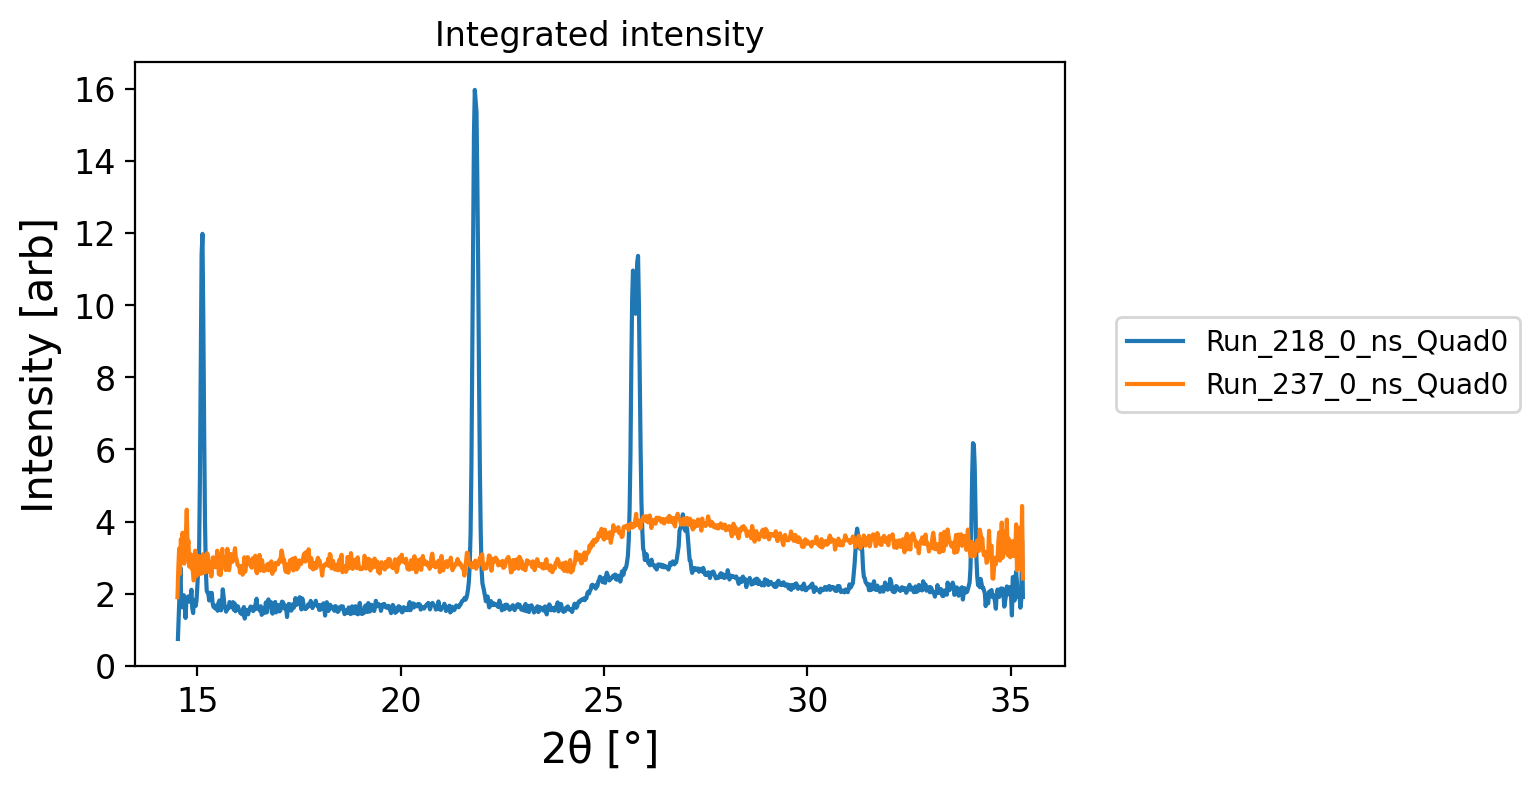

In [64]:
%matplotlib inline
plt.rcParams['figure.dpi']= 200

run_number = 'run218'
quad_2_plot = 0
counter = run_numbers_list.index(run_number)
plt.plot(int_1D_all[run_number]["Quad{0}".format(quad_2_plot)][0][:], int_1D_all[run_number]["Quad{0}".format(quad_2_plot)][1][:]\
         , label = label_list[counter] + "_Quad{0}".format(quad_2_plot))

run_number = 'run237'
#quad_2_plot = 3
counter = run_numbers_list.index(run_number)
plt.plot(int_1D_all[run_number]["Quad{0}".format(quad_2_plot)][0][:], int_1D_all[run_number]["Quad{0}".format(quad_2_plot)][1][:]\
         , label = label_list[counter] + "_Quad{0}".format(quad_2_plot))

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('2\u03B8 [\N{DEGREE SIGN}]',fontsize=15)
plt.ylabel('Intensity [arb]',fontsize=15)
plt.title("Integrated intensity")
#plt.ylim([10, 20])
plt.legend(loc = 'center left', bbox_to_anchor = (1.04, 0.5))
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

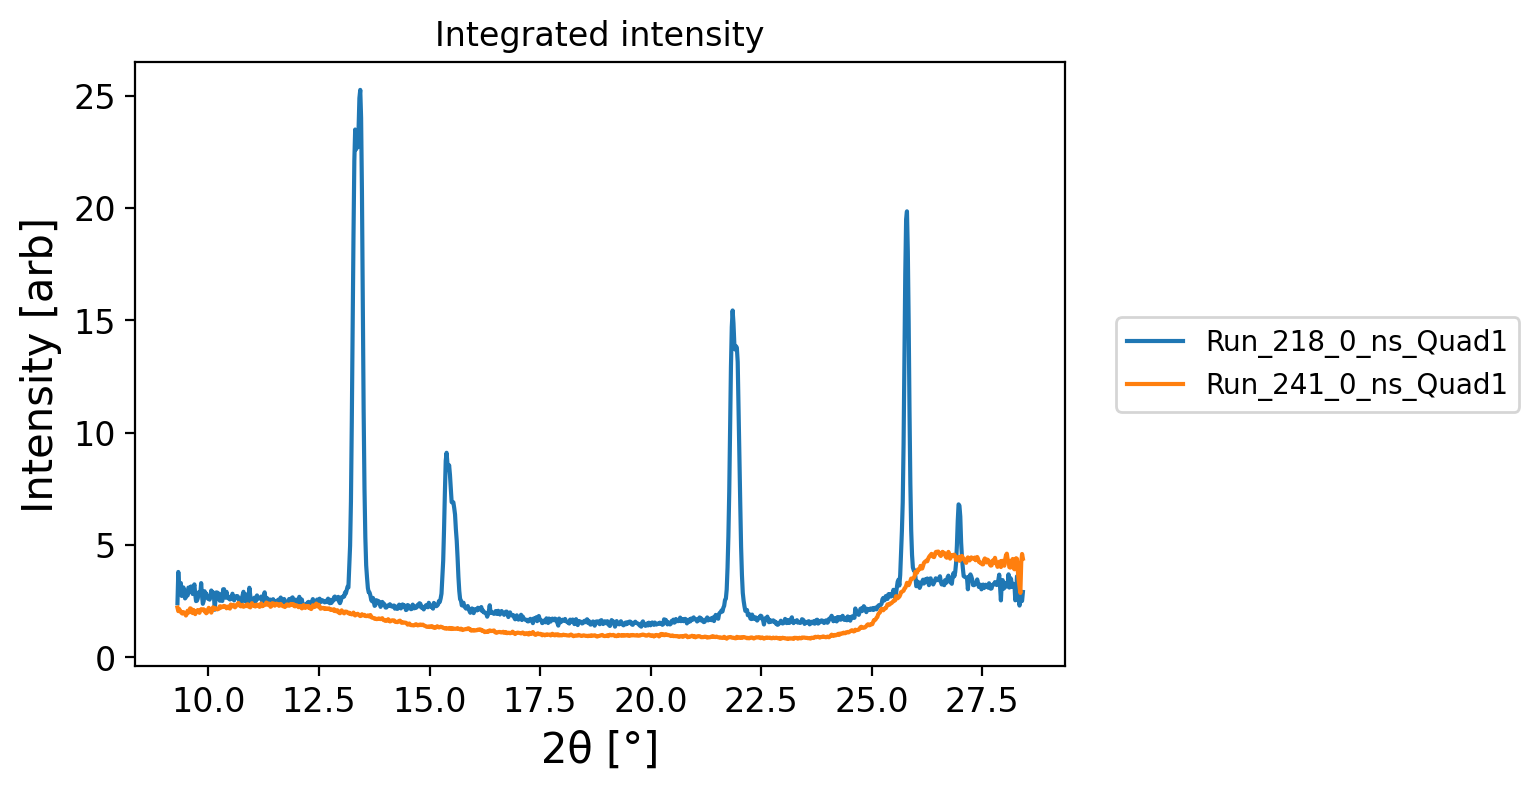

In [65]:
%matplotlib inline
plt.rcParams['figure.dpi']= 200

run_number = 'run218'
quad_2_plot = 1
counter = run_numbers_list.index(run_number)
plt.plot(int_1D_all[run_number]["Quad{0}".format(quad_2_plot)][0][:], int_1D_all[run_number]["Quad{0}".format(quad_2_plot)][1][:]\
         , label = label_list[counter] + "_Quad{0}".format(quad_2_plot))

run_number = 'run241'
#quad_2_plot = 3
counter = run_numbers_list.index(run_number)
plt.plot(int_1D_all[run_number]["Quad{0}".format(quad_2_plot)][0][:], int_1D_all[run_number]["Quad{0}".format(quad_2_plot)][1][:]\
         , label = label_list[counter] + "_Quad{0}".format(quad_2_plot))

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('2\u03B8 [\N{DEGREE SIGN}]',fontsize=15)
plt.ylabel('Intensity [arb]',fontsize=15)
plt.title("Integrated intensity")
#plt.ylim([10, 20])
plt.legend(loc = 'center left', bbox_to_anchor = (1.04, 0.5))
plt.show

In [66]:
%matplotlib inline
plt.rcParams['figure.dpi']= 200

run_number = 'run286'
quad_2_plot = 2
counter = run_numbers_list.index(run_number)
plt.plot(int_1D_all[run_number]["Quad{0}".format(quad_2_plot)][0][:], int_1D_all[run_number]["Quad{0}".format(quad_2_plot)][1][:]\
         , label = label_list[counter] + "_Quad{0}".format(quad_2_plot))

run_number = 'run416'
#quad_2_plot = 3
counter = run_numbers_list.index(run_number)
plt.plot(int_1D_all[run_number]["Quad{0}".format(quad_2_plot)][0][:], int_1D_all[run_number]["Quad{0}".format(quad_2_plot)][1][:]\
         , label = label_list[counter] + "_Quad{0}".format(quad_2_plot))

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('2\u03B8 [\N{DEGREE SIGN}]',fontsize=15)
plt.ylabel('Intensity [arb]',fontsize=15)
plt.title("Integrated intensity")
#plt.ylim([10, 20])
plt.legend(loc = 'center left', bbox_to_anchor = (1.04, 0.5))
plt.show

ValueError: 'run286' is not in list

<function matplotlib.pyplot.show(close=None, block=None)>

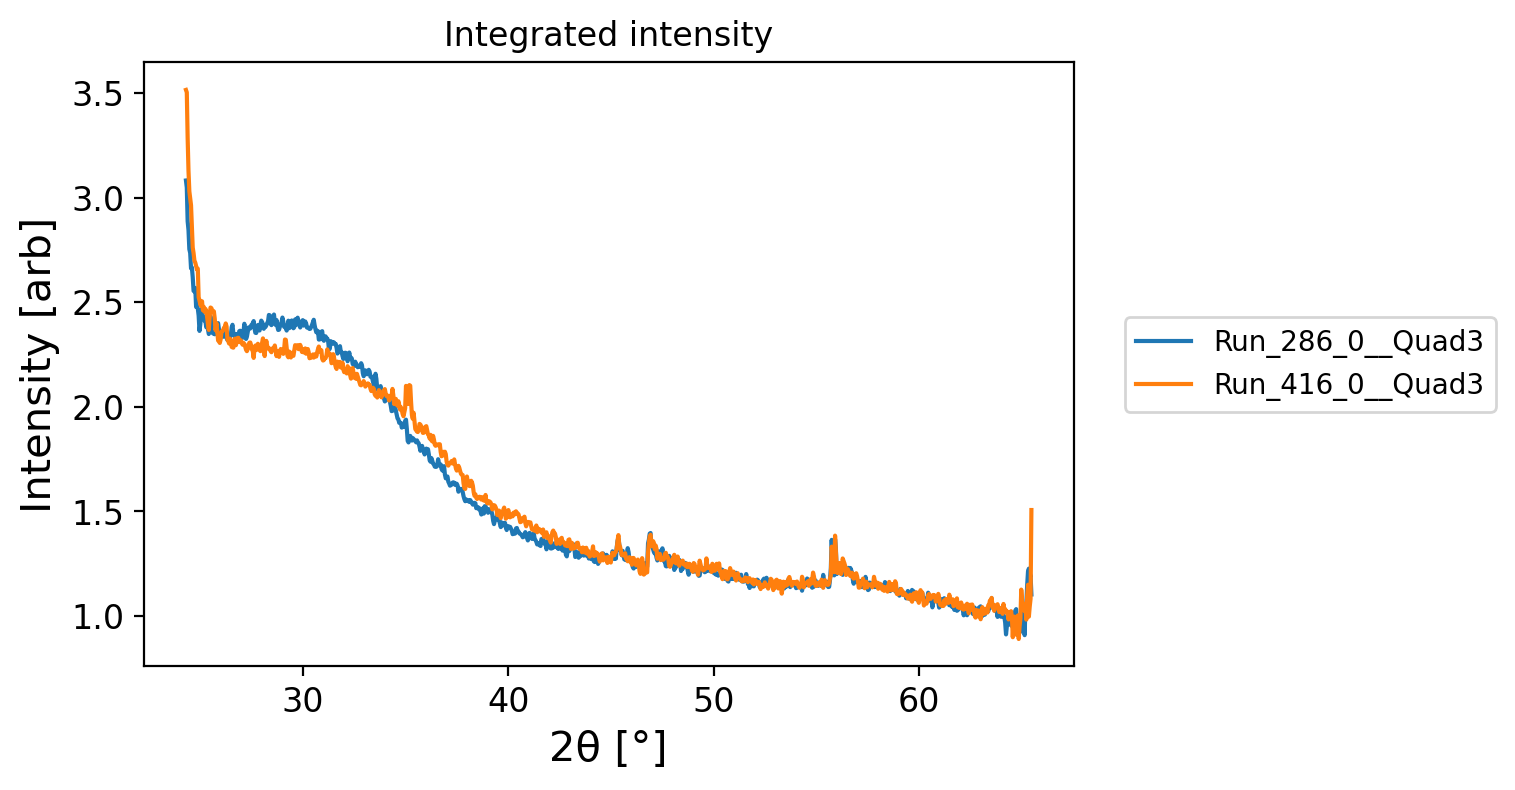

In [26]:
%matplotlib inline
plt.rcParams['figure.dpi']= 200

run_number = 'run286'
quad_2_plot = 3
counter = run_numbers_list.index(run_number)
plt.plot(int_1D_all[run_number]["Quad{0}".format(quad_2_plot)][0][:], int_1D_all[run_number]["Quad{0}".format(quad_2_plot)][1][:]\
         , label = label_list[counter] + "_Quad{0}".format(quad_2_plot))

run_number = 'run416'
#quad_2_plot = 3
counter = run_numbers_list.index(run_number)
plt.plot(int_1D_all[run_number]["Quad{0}".format(quad_2_plot)][0][:], int_1D_all[run_number]["Quad{0}".format(quad_2_plot)][1][:]\
         , label = label_list[counter] + "_Quad{0}".format(quad_2_plot))

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('2\u03B8 [\N{DEGREE SIGN}]',fontsize=15)
plt.ylabel('Intensity [arb]',fontsize=15)
plt.title("Integrated intensity")
#plt.ylim([10, 20])
plt.legend(loc = 'center left', bbox_to_anchor = (1.04, 0.5))
plt.show

# 2D cake images

In [15]:
int_2D_all = {}
counter = 0
# Integrating
for run_number in run_numbers_list:
    int_2D_temp = {}
    for i in range(0, nb_file_calib):
        img_array = run_imgs[run_number]["Quad{0}".format(i)]
        mask1 = img_array<1
        mask2 = img_array>500
        mask = mask1+mask2
        ai_dic["Quad{0}".format(i)].wavelength = lams[counter]
        int_2D_temp["Quad{0}".format(i)] = ai_dic["Quad{0}".format(i)].integrate2d(img_array, 500, 360, unit="2th_deg", polarization_factor=0.99, method='full_csr')
        print("Done Integrating", run_number, "Quad{0}".format(i), "\n")
    counter = counter + 1
    int_2D_all[run_number] = int_2D_temp

Done Integrating run459 Quad0 

Done Integrating run459 Quad1 

Done Integrating run459 Quad2 

Done Integrating run459 Quad3 

Done Integrating run460 Quad0 

Done Integrating run460 Quad1 

Done Integrating run460 Quad2 

Done Integrating run460 Quad3 

Done Integrating run467 Quad0 

Done Integrating run467 Quad1 

Done Integrating run467 Quad2 

Done Integrating run467 Quad3 

Done Integrating run473 Quad0 

Done Integrating run473 Quad1 

Done Integrating run473 Quad2 

Done Integrating run473 Quad3 

Done Integrating run476 Quad0 

Done Integrating run476 Quad1 

Done Integrating run476 Quad2 

Done Integrating run476 Quad3 

Done Integrating run479 Quad0 

Done Integrating run479 Quad1 

Done Integrating run479 Quad2 

Done Integrating run479 Quad3 

Done Integrating run482 Quad0 

Done Integrating run482 Quad1 

Done Integrating run482 Quad2 

Done Integrating run482 Quad3 

Done Integrating run540 Quad0 

Done Integrating run540 Quad1 

Done Integrating run540 Quad2 

Done Int

In [25]:
from pyFAI.gui import jupyter

In [26]:
run_to_plot = 'run540'

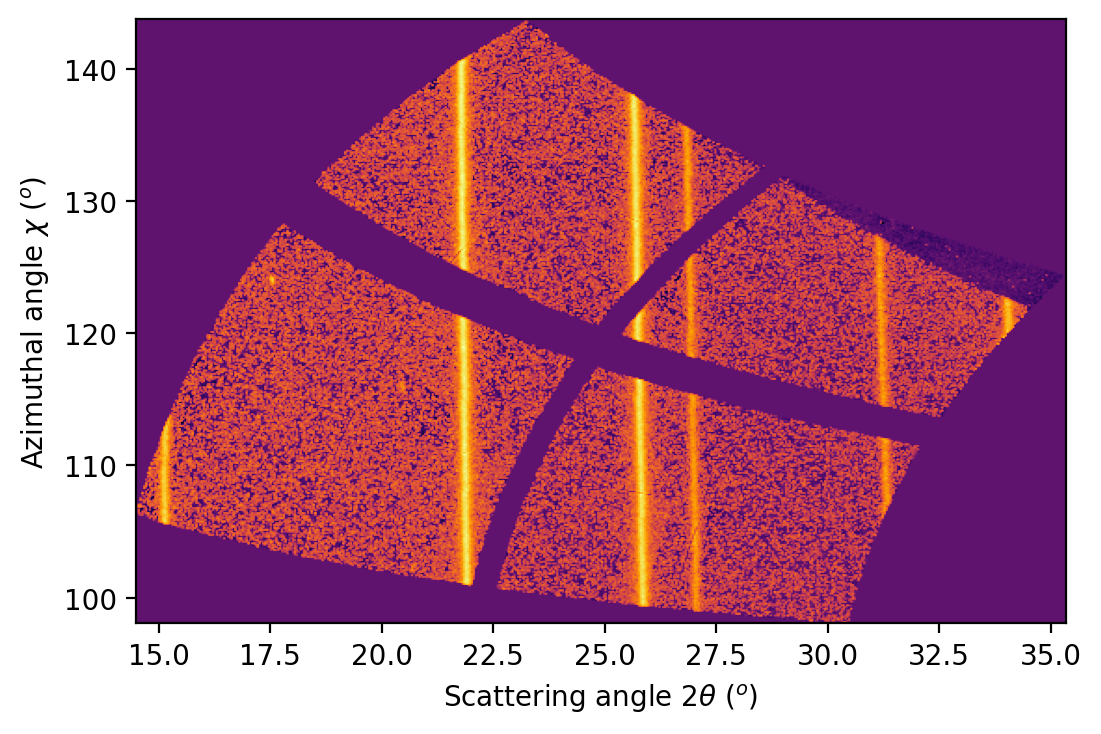

In [27]:

quad_2_plot = 0
ax = jupyter.plot2d(int_2D_all[run_to_plot]["Quad{0}".format(quad_2_plot)])

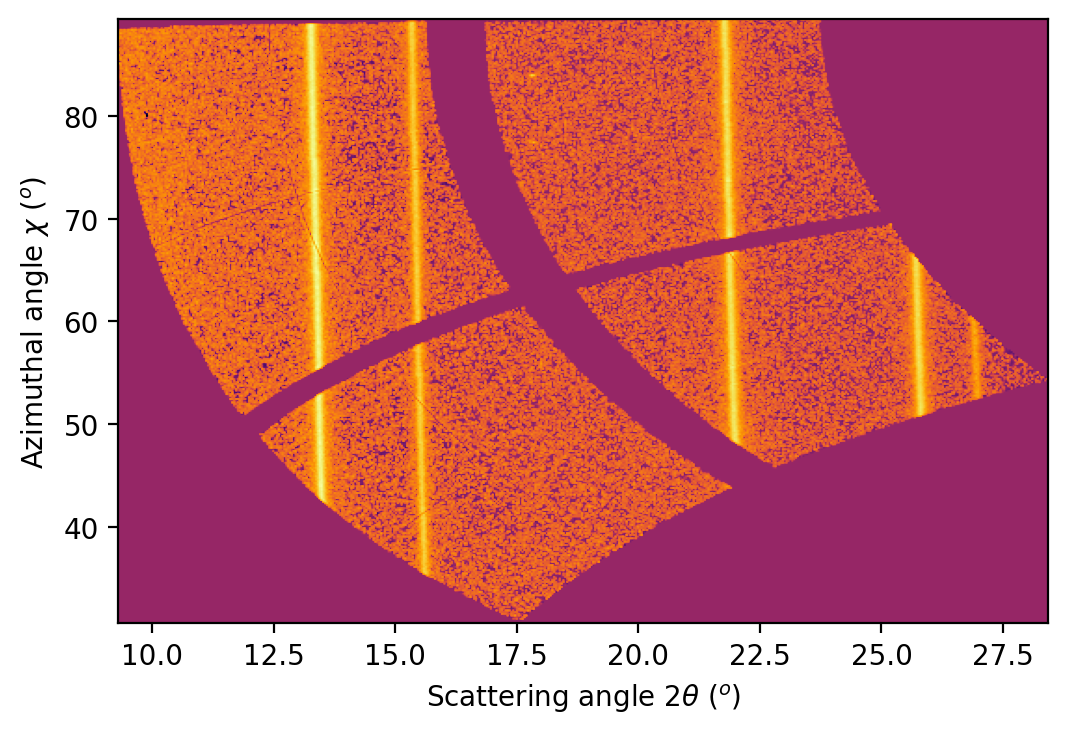

In [28]:
#run_to_plot = 'run237'
quad_2_plot = 1
ax = jupyter.plot2d(int_2D_all[run_to_plot]["Quad{0}".format(quad_2_plot)])

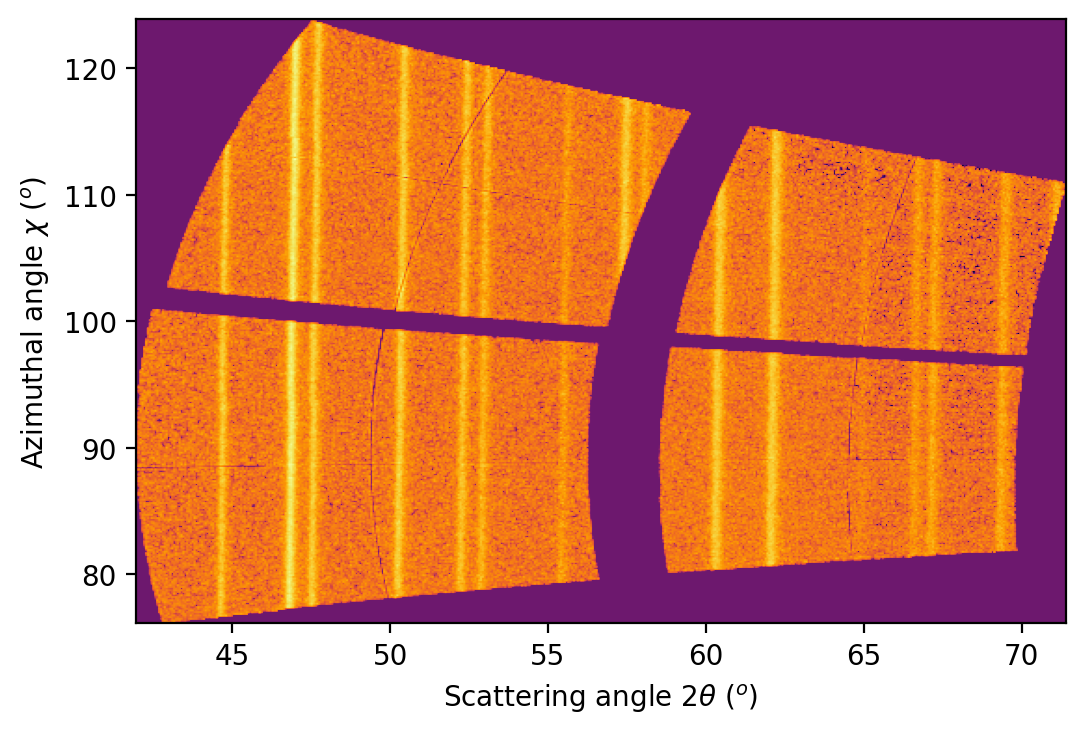

In [29]:
#run_to_plot = 'run237'
quad_2_plot = 2
ax = jupyter.plot2d(int_2D_all[run_to_plot]["Quad{0}".format(quad_2_plot)])

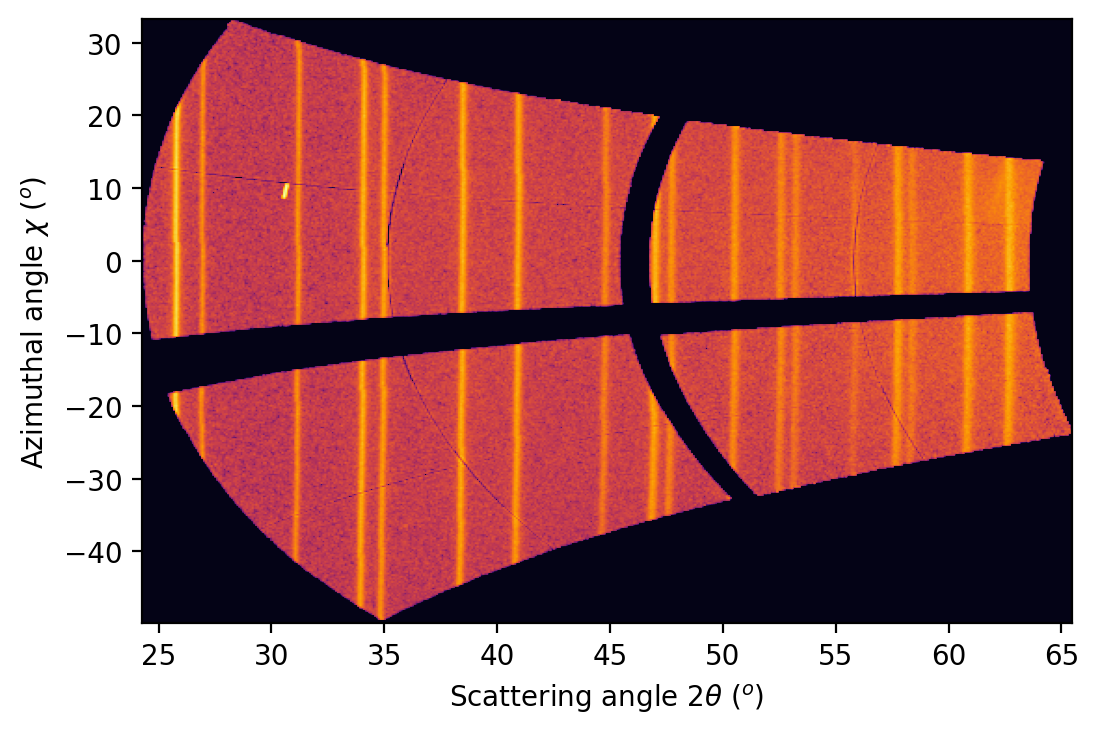

In [30]:
#run_to_plot = 'run237'
quad_2_plot = 3
ax = jupyter.plot2d(int_2D_all[run_to_plot]["Quad{0}".format(quad_2_plot)])

In [24]:
run_to_plot = 'run314'
quad_2_plot = 0

#fig, ax = subplots(1,2, figsize=(15,5))
I, tth, chi = int_2D_all[run_to_plot]["Quad{0}".format(quad_2_plot)]
plt.imshow(I, origin="lower", extent=[tth.min(), tth.max(), chi.min(), chi.max()], aspect="auto", vmin=0, vmax=150)
plt.xlabel("2 theta (deg)")
plt.ylabel("Azimuthal angle chi (deg)")
plt.colorbar()

KeyError: 'run314'

In [ ]:
run_to_plot = 'run314'
quad_2_plot = 1

#fig, ax = subplots(1,2, figsize=(15,5))
I, tth, chi = int_2D_all[run_to_plot]["Quad{0}".format(quad_2_plot)]
plt.imshow(I, origin="lower", extent=[tth.min(), tth.max(), chi.min(), chi.max()], aspect="auto", vmin=0, vmax=150)
plt.xlabel("2 theta (deg)")
plt.ylabel("Azimuthal angle chi (deg)")
plt.colorbar()

# End